In [38]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# load data
offer_data = pd.read_csv('data/cleaned_offer_data.csv')

# Introduction

This notebook documents an analysis of the probability of completing various promotional offers based on Starbucks data. The notebook uses a cleaned data set on offers received by each user that was created in a separate notebook (starbucks_data_cleanup.ipynb).

The overall idea for the analysis is to use a machine learning algorithm to predict whether users complete (redeem) the offers from existing data on users and offers. We can then use models with sufficient predictive power to compare predicted probabilities of completing the offers for different segments of customers or for offers with different characteristics. In this analysis, we will mainly use logistic regression, as it usually performs well with respect to binary predictions, and it also allows us to examine the contribution of each predictor by looking at regression coefficients. We will also look at who is more likely to view offers using the same model setup.

At the end of the analysis, there is a discussion of the takeaways and possible improvements.

# Setting Up

First, we create several dummy variables for segments of the customer base based on age, income, gender, and when one became a member. As for age, standard age group ranges (0--20, 21--30, etc.) were used. Incomes in the data set were in the range from 30,000 to 120,000, so 20K brackets were used except for the first one (0--40). Membership duration was split into five bins: 0-3 months, 4-6 months, 7-12 months, 1-2 years, more than 2 years. We also add dummies for offer types: BOGO, discount, and informational (informational offers will not be used in this analysis as they cannot be 'completed').

In [39]:
# turn continuous variables to categorical
offer_data['age_group'] = pd.cut(
    offer_data.age, bins=[0, 20, 30, 40, 50, 60, 150],
    labels=['18-20', '21-30', '31-40', '41-50', '51-60', '61+'])
offer_data['income_group'] = pd.cut(
    offer_data.income, bins=[0, 40000, 60000, 80000, 100000, 120000],
    labels=['0-40K', '41-60K', '61-80K', '81-100K', '101-120K'])
offer_data['member_months_group'] = pd.cut(
    offer_data.member_months, bins=[0, 3, 6, 12, 24, 1000],
    labels=['0-3 months', '4-6 months', '7-12 months', 
            '1-2 years', '2+ years'])

# recode offer ids
offer_data['offer_id_alt'] = (offer_data.offer_type + ' ') + (
    offer_data.offer_reward.astype(str) + ' (') + (
        (offer_data.offer_duration/24).astype(int).astype(str) + ' days)')
        
# drop informational offers
offer_data = offer_data[offer_data.offer_type != 'informational']

# create dummies
offer_data = pd.concat([offer_data,
                            pd.get_dummies(offer_data['age_group'],
                                           prefix='Age'),
                            pd.get_dummies(offer_data['income_group'],
                                           prefix='Income'),
                            pd.get_dummies(offer_data['gender'],
                                           prefix='Gender'),
                            pd.get_dummies(offer_data['member_months_group'], 
                                           prefix='Member'),
                            pd.get_dummies(offer_data['offer_type'], 
                                           prefix='Type'),
                            pd.get_dummies(offer_data['offer_id_alt'], 
                                           prefix='Offer')],
                            axis=1)
                            

Next, we set up functions to split the data into train and test sets and to fit the models.

In this case, instead of using the standard train_test_split function, it is reasonable to split the data into train and test sets at the level of the user. For this purpose, we use a custom splitting function below.

In [40]:
def train_test_split_by_user(X, y):
    
    '''
    Create a train and test list of user ids, then split the data accordingly.
    
    Args:
        X: a data frame of predictors
        y: the target variable (pandas series)
    '''
    
    # create train and test sets of users
    train_ix, test_ix = next(gss.split(X, y, groups=X.user_id))
    
    # split into train and test
    X = X.drop(columns='user_id')
    X_train = X.iloc[train_ix]
    y_train = y.iloc[train_ix]
    X_test = X.iloc[test_ix]
    y_test = y.iloc[test_ix]
    
    return X_train, y_train, X_test, y_test

# initialize the command for splitting the data
gss = GroupShuffleSplit(n_splits=2, test_size=0.3, random_state=42)

The following function fits the models, outputs model evaluation, and, in case of logistic regression models, saves the regression coefficients for the subsequent interpretation.

In [41]:
def fit_test(model_pipeline, return_coefs=False):
    
    '''
    Fit the model, print out model evaluations on test data,
    return coefficients.
    
    Args:
        model_pipeline: a pipeline/a model object
    '''
    
    # Fit the model
    model_pipeline.fit(X_train, y_train)
    
    # Test the model
    y_pred = model_pipeline.predict(X_test)
    
    print('F1 score:')
    print(round(f1_score(y_test, y_pred), 3))
    print('Precision:')
    print(round(precision_score(y_test, y_pred), 3))
    print('Recall:')
    print(round(recall_score(y_test, y_pred), 3))
    
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model_pipeline, X_test, y_test, 
                                          normalize='all')
    
    if return_coefs:
        coefs = pd.DataFrame({'var': X_train.columns.tolist(),
                              'coef': model_pipeline.named_steps[
                              'logit'].coef_.flatten()})
        return coefs
    
    else:
        return None

For this analysis, we set up two model pipelines, one using logistic regression, and another using gradient boosting. In both cases, data are normalized using a MinMaxScaler from sklearn, which rescales each variable to take values from 0 to 1. This is more appropriate in this case compared to standard centering and scaling because many of the variables are dummies.

In [42]:
# instantiate model pipelines
pipeline_logit = Pipeline([
    ('scaler', MinMaxScaler()),
    ('logit', LogisticRegression())
])

pipeline_boost = Pipeline([
    ('scaler', MinMaxScaler()),
    ('boost', GradientBoostingClassifier(random_state=42))
])

In the analysis below, we will use the following set of predictors:
- Dummies for promo campaigns (offers). While the data contain several characteristics for each offer, such as its type, reward, duration, and required spending, there are just 8 offers in this analysis (after dropping 2 informational ones), and including all these specific characteristics will be essentially the same as including just the offer ids, as the set of these features allows to identify each offer precisely (see the list of offers below). It would thus be easier to interpret the results if we include just the dummies for each offer. The dummy 'bogo 5 (5 days)' is omitted and serves as the reference category.
- The count of previously completed offers by the same user (one variable counts offers with the same id, the other variable counts all previously completed offers). This allows us to capture whether one tends to spend more or to seek offers more actively.
- Age groups. The group 'Age 18-20' serves as a reference category.
- Income groups. The group '0-40K' serves as a reference category.
- Gender. 'Male' is the reference category.
- How long one has been a member. '0-3 months' is a reference category.

In [43]:
print('Offers in the analysis (the number after offer type is reward value in dollars):')
print(offer_data.sort_values('offer_id_alt').offer_id_alt.unique().tolist())

x_vars = ['Offer_bogo 10 (5 days)', 'Offer_bogo 10 (7 days)', 
          'Offer_bogo 5 (7 days)',
          'Offer_discount 2 (7 days)',  'Offer_discount 2 (10 days)',
          'Offer_discount 3 (7 days)', 'Offer_discount 5 (10 days)', 
          'same_offer_completed_before', 'any_offer_completed_before',
          'Age_21-30', 'Age_31-40', 'Age_41-50', 'Age_51-60', 'Age_61+',
          'Income_41-60K', 'Income_61-80K', 'Income_81-100K', 
          'Income_101-120K', 
          'Gender_Female', 'Gender_Other', 
          'Member_4-6 months', 'Member_7-12 months',
          'Member_1-2 years', 'Member_2+ years']

Offers in the analysis (the number after offer type is reward value in dollars):
['bogo 10 (5 days)', 'bogo 10 (7 days)', 'bogo 5 (5 days)', 'bogo 5 (7 days)', 'discount 2 (10 days)', 'discount 2 (7 days)', 'discount 3 (7 days)', 'discount 5 (10 days)']


Next, we create a matrix of predictors X and the outcome variable, and then we split the data into the training and test sets.

In [44]:
# X and y
offer_data_X = offer_data[['user_id'] + x_vars]
offer_data_y = offer_data['completed']

# train and test
X_train, y_train, X_test, y_test = train_test_split_by_user(offer_data_X,
                                                            offer_data_y)

# Analysis

## Finding the Best-Performing Model

### Logistic Regression

The logistic regression implementation in sklearn by default includes a regularization penalty, but the strength of regularization could be tuned via the parameter called C. First, we use grid search with cross-validation to find the optimal value of C.



F1 score:
0.799
Precision:
0.774
Recall:
0.826
Confusion matrix:
[[3557 2401]
 [1733 8221]]


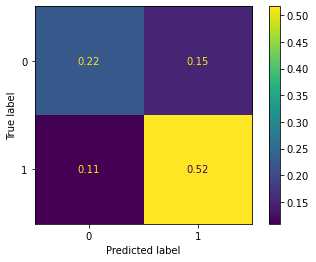

In [45]:
# grid search for optimal model parameters
parameters_logit = {
        'logit__C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100, 1000]
    }
logit_cv = GridSearchCV(pipeline_logit, param_grid=parameters_logit)
fit_test(logit_cv)

The best model has an F1 score of 0.8, which is pretty good. EXPLAIN F1 SCORE AND TALK ABT PRECISION/RECALL, PRECISION SOMEWHAT LOWER THAN RECALL.

The optimal value of C is 10, as shown below, so this is what we will use going forward.

In [46]:
print('Optimal parameter: ' + str(logit_cv.best_params_))

Optimal parameter: {'logit__C': 10}


### Gradient Boosting

As an alternative, we'll consider another classifier, gradient boosting, also implemented in sklearn. This is an ensemble tree-based model. In this case, we'll tune three parameters: learning rate (the contribution of each tree to final predictions), the number of estimators (boosting stages), and max depth (the number of nodes in each tree).

F1 score:
0.803
Precision:
0.783
Recall:
0.824
Confusion matrix:
[[3682 2276]
 [1750 8204]]


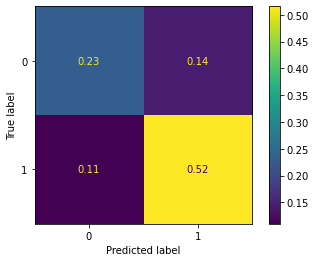

In [47]:
# grid search for optimal parameters
parameters_boost = {
        'boost__max_depth': [1, 2, 3, 4, 5],
        'boost__n_estimators': [10, 50, 100, 200],
        'boost__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    }
boost_cv = GridSearchCV(pipeline_boost, param_grid=parameters_boost)
fit_test(boost_cv)


Here are the optimal parameters for this model. As the results above show, the F1 score of the gradient boosting classifier is almost the same as in the logistic regression case above (slightly lower recall and slightly higher precision). Given that the logistic regression model allows for easier interpretation of results based on regression coefficients, we will use it for the remaining analysis.

In [48]:
print(boost_cv.best_params_)

{'boost__learning_rate': 0.2, 'boost__max_depth': 3, 'boost__n_estimators': 100}


## Predicting Offer Completion

